# 26. GAN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 26.1 Preparing MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

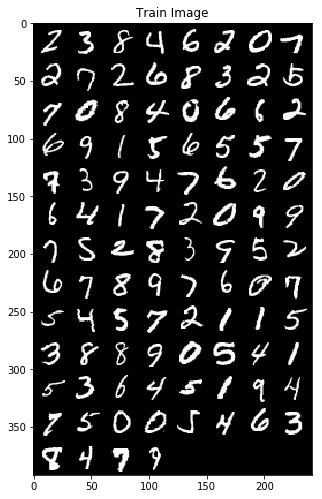

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 26.2 Define Model

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(28*28, 500),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(500, 250),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(250, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        out = self.discriminator(x)
        return out

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(100, 250),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(250, 500),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(500, 28*28),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.generator(x)
        out = out.view(-1, 1, 28, 28)
        return out

In [9]:
D = Discriminator().cuda()
G = Generator().cuda()

## 26.3 Model Training

In [10]:
def gan_loss(x, target_is_real):
    
    loss = nn.BCELoss()
    
    if target_is_real : 
        target_tensor = torch.ones(batch_size, 1)
    else :
        target_tensor = torch.zeros(batch_size, 1)
        
    return loss(x, Variable(target_tensor).cuda())

In [11]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = optim.Adam(D.parameters(), lr=0.0001)

In [12]:
num_epochs = 50

In [13]:
for epoch in range(num_epochs):
        
    total_batch = len(mnist_train) // batch_size
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images).cuda()
            
        prob_real = D(images)
        D_loss_real = gan_loss(prob_real, True)

        z = Variable(torch.randn((batch_size, 100))).cuda()
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        D_loss_fake = gan_loss(prob_fake, False)
        
        D_loss = D_loss_real + D_loss_fake
        
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        z = Variable(torch.randn((batch_size, 100))).cuda()
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        G_loss = gan_loss(prob_fake, True)
        
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, D_loss.data[0], G_loss.data[0]))

Epoch [1/50], lter [100/600], D_Loss: 0.8593, G_Loss: 1.5582
Epoch [1/50], lter [200/600], D_Loss: 0.6122, G_Loss: 1.9939
Epoch [1/50], lter [300/600], D_Loss: 0.7175, G_Loss: 2.0405
Epoch [1/50], lter [400/600], D_Loss: 1.1152, G_Loss: 1.0950
Epoch [1/50], lter [500/600], D_Loss: 1.3071, G_Loss: 0.9733
Epoch [1/50], lter [600/600], D_Loss: 1.3199, G_Loss: 1.1500
Epoch [2/50], lter [100/600], D_Loss: 1.6102, G_Loss: 0.6406
Epoch [2/50], lter [200/600], D_Loss: 1.2069, G_Loss: 0.8998
Epoch [2/50], lter [300/600], D_Loss: 1.4707, G_Loss: 0.6607
Epoch [2/50], lter [400/600], D_Loss: 1.2409, G_Loss: 0.6824
Epoch [2/50], lter [500/600], D_Loss: 0.8745, G_Loss: 0.9282
Epoch [2/50], lter [600/600], D_Loss: 0.9828, G_Loss: 0.8979
Epoch [3/50], lter [100/600], D_Loss: 0.7469, G_Loss: 1.2571
Epoch [3/50], lter [200/600], D_Loss: 0.8638, G_Loss: 1.8728
Epoch [3/50], lter [300/600], D_Loss: 0.5250, G_Loss: 2.9728
Epoch [3/50], lter [400/600], D_Loss: 0.3929, G_Loss: 2.4324
Epoch [3/50], lter [500/

Epoch [23/50], lter [300/600], D_Loss: 0.6101, G_Loss: 2.2304
Epoch [23/50], lter [400/600], D_Loss: 0.4988, G_Loss: 2.2304
Epoch [23/50], lter [500/600], D_Loss: 0.5602, G_Loss: 2.4530
Epoch [23/50], lter [600/600], D_Loss: 0.5261, G_Loss: 2.4073
Epoch [24/50], lter [100/600], D_Loss: 0.4831, G_Loss: 2.9360
Epoch [24/50], lter [200/600], D_Loss: 0.6433, G_Loss: 2.4238
Epoch [24/50], lter [300/600], D_Loss: 0.6181, G_Loss: 2.5849
Epoch [24/50], lter [400/600], D_Loss: 0.4845, G_Loss: 2.4913
Epoch [24/50], lter [500/600], D_Loss: 0.5051, G_Loss: 2.9028
Epoch [24/50], lter [600/600], D_Loss: 0.6415, G_Loss: 2.4774
Epoch [25/50], lter [100/600], D_Loss: 0.5059, G_Loss: 2.4107
Epoch [25/50], lter [200/600], D_Loss: 0.6079, G_Loss: 2.4853
Epoch [25/50], lter [300/600], D_Loss: 0.5250, G_Loss: 2.6096
Epoch [25/50], lter [400/600], D_Loss: 0.4022, G_Loss: 2.8801
Epoch [25/50], lter [500/600], D_Loss: 0.5057, G_Loss: 2.6090
Epoch [25/50], lter [600/600], D_Loss: 0.4811, G_Loss: 2.5801
Epoch [2

Epoch [45/50], lter [400/600], D_Loss: 0.5855, G_Loss: 2.4979
Epoch [45/50], lter [500/600], D_Loss: 0.5464, G_Loss: 2.6532
Epoch [45/50], lter [600/600], D_Loss: 0.5046, G_Loss: 2.4377
Epoch [46/50], lter [100/600], D_Loss: 0.4913, G_Loss: 2.6428
Epoch [46/50], lter [200/600], D_Loss: 0.8163, G_Loss: 2.6281
Epoch [46/50], lter [300/600], D_Loss: 0.5069, G_Loss: 2.7523
Epoch [46/50], lter [400/600], D_Loss: 0.6450, G_Loss: 2.7723
Epoch [46/50], lter [500/600], D_Loss: 0.5175, G_Loss: 2.8143
Epoch [46/50], lter [600/600], D_Loss: 0.6726, G_Loss: 2.6685
Epoch [47/50], lter [100/600], D_Loss: 0.6063, G_Loss: 2.6890
Epoch [47/50], lter [200/600], D_Loss: 0.5376, G_Loss: 2.7080
Epoch [47/50], lter [300/600], D_Loss: 0.5427, G_Loss: 2.2722
Epoch [47/50], lter [400/600], D_Loss: 0.7223, G_Loss: 2.5496
Epoch [47/50], lter [500/600], D_Loss: 0.5710, G_Loss: 2.7387
Epoch [47/50], lter [600/600], D_Loss: 0.5838, G_Loss: 2.7605
Epoch [48/50], lter [100/600], D_Loss: 0.5269, G_Loss: 2.5807
Epoch [4

## 26.4 Test Model

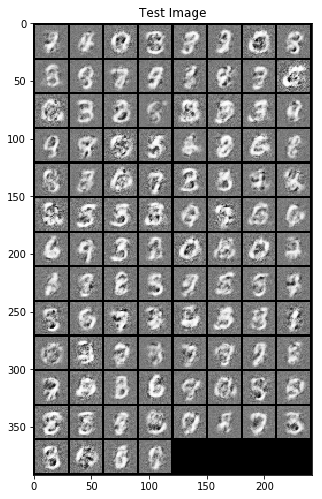

In [14]:
z = Variable(torch.randn((batch_size, 100))).cuda()
images = G(z)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Test Image")